# 3D Image Classification

Learn how to train a 3D convolutional neural network (3D CNN) to predict presence of pneumonia - based on [Tutorial on 3D Image Classification](https://keras.io/examples/vision/3D_image_classification/) by [Hasib Zunair](https://github.com/hasibzunair).


> __Dataset__: [MosMedData: Chest CT Scans with COVID-19 Related Findings Dataset](https://www.medrxiv.org/content/10.1101/2020.05.20.20100362v1) :: This dataset contains anonymised human lung computed tomography (CT) scans with COVID-19 related findings, as well as without such findings. A small subset of studies has been annotated with binary pixel masks depicting regions of interests (ground-glass opacifications and consolidations). CT scans were obtained between 1st of March, 2020 and 25th of April, 2020, and provided by municipal hospitals in Moscow, Russia.

## Verify GPU Support

In [2]:
# importing tensorflow
import tensorflow as tf

device_name = tf.test.gpu_device_name()
print('Active GPU :: {}'.format(device_name))
# Active GPU :: /device:GPU:0

2023-04-17 15:07:26.878590: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Active GPU :: /device:GPU:0


2023-04-17 15:07:28.916076: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-17 15:07:28.939689: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-17 15:07:28.939920: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

## Import Dependencies

In [3]:
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import os
import random
from scipy import ndimage
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model

In [4]:
# helper functions
from helper import (read_scan,
                    normalize,
                    resize_volume,
                    process_scan,
                    rotate,
                    train_preprocessing,
                    validation_preprocessing,
                    plot_slices,
                    build_model)

## Import Dataset

In [4]:
# download from https://github.com/hasibzunair/3D-image-classification-tutorial/releases/
data_dir = './dataset'
no_pneumonia = os.path.join(data_dir, 'no_viral_pneumonia')
with_pneumonia = os.path.join(data_dir, 'with_viral_pneumonia')

normal_scan_paths = [
    os.path.join(no_pneumonia, i)
    for i in os.listdir(no_pneumonia)
]
print('INFO :: CT Scans with normal lung tissue:', len(normal_scan_paths))

abnormal_scan_paths = [
    os.path.join(with_pneumonia, i)
    for i in os.listdir(with_pneumonia)
]
print('INFO :: CT Scans with abnormal lung tissue:', len(abnormal_scan_paths))

# INFO :: CT Scans with normal lung tissue: 100
# INFO :: CT Scans with abnormal lung tissue: 100

INFO :: CT Scans with normal lung tissue: 100
INFO :: CT Scans with abnormal lung tissue: 100


## Visualize Dataset

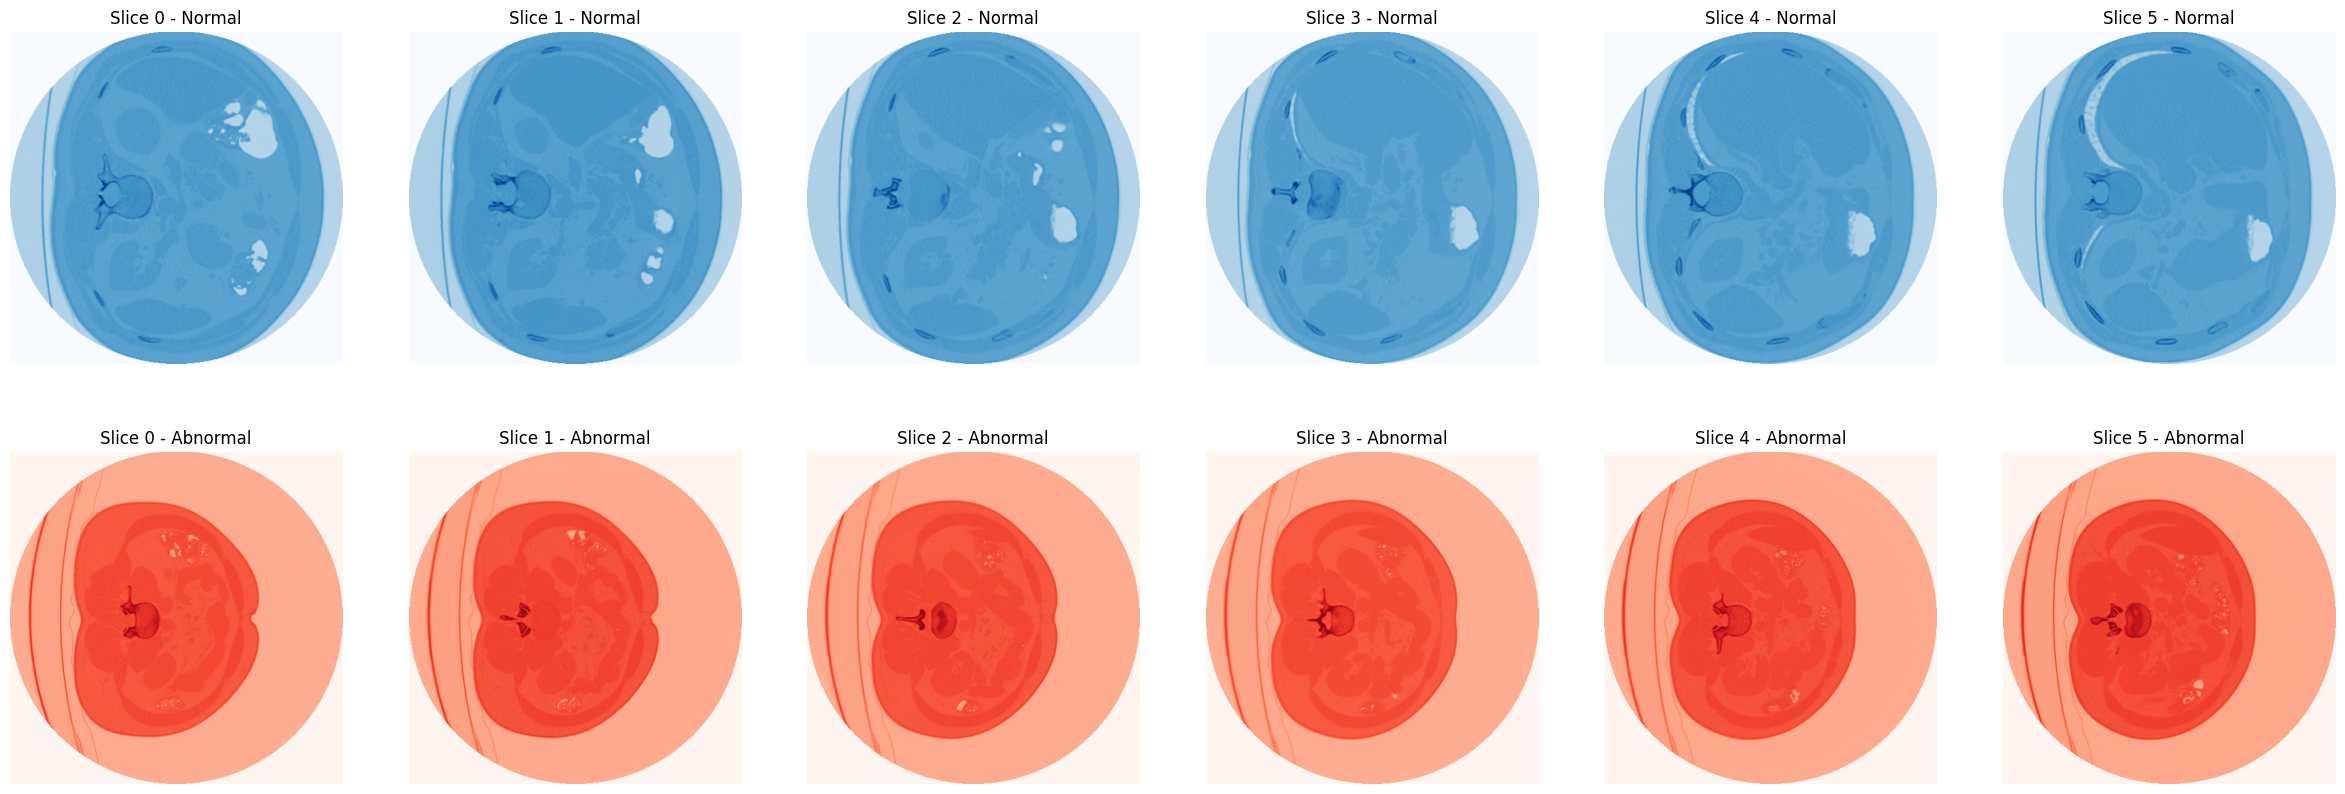

In [6]:
img_normal = nib.load(normal_scan_paths[0])
img_normal_array = img_normal.get_fdata()

img_abnormal = nib.load(abnormal_scan_paths[0])
img_abnormal_array = img_abnormal.get_fdata()

plt.figure(figsize=(30,10))

for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.imshow(img_normal_array[:, :, i], cmap='Blues')
    plt.axis('off')
    plt.title('Slice {} - Normal'.format(i))
    
    plt.subplot(2, 6, 6+i+1)
    plt.imshow(img_abnormal_array[:, :, i], cmap='Reds')
    plt.axis('off')
    plt.title('Slice {} - Abnormal'.format(i))

![3D Image Classification](./assets/3D_Image_Classification_01.png)

## Data Pre-processing

### Normalization

In [7]:
# Read and process the scans.
# Each scan is resized across height, width, and depth and rescaled.
abnormal_scans = np.array([process_scan(path) for path in abnormal_scan_paths])
normal_scans = np.array([process_scan(path) for path in normal_scan_paths])

In [8]:
# For the CT scans having presence of viral pneumonia
# assign 1, for the normal ones assign 0.
abnormal_labels = np.array([1 for _ in range(len(abnormal_scans))])
normal_labels = np.array([0 for _ in range(len(normal_scans))])

### Train Test Split

In [9]:
X = np.concatenate((abnormal_scans, normal_scans), axis=0)
Y = np.concatenate((abnormal_labels, normal_labels), axis=0)

x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.3, random_state=42)
print('INFO :: Train / Test Samples - %d / %d' % (x_train.shape[0], x_val.shape[0]))
# INFO :: Train / Test Samples - 140 / 60

INFO :: Train / Test Samples - 140 / 60


### Data Augmentation

#### Data Loader

In [10]:
# Define data loaders.
train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((x_val, y_val))
batch_size = 2

# Augment the on the fly during training.
train_dataset = (
    train_loader.shuffle(len(x_train))
    .map(train_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)
# Only rescale.
validation_dataset = (
    validation_loader.shuffle(len(x_val))
    .map(validation_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)

2023-04-17 14:16:27.062526: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-17 14:16:27.062955: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-17 14:16:27.063202: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

### Visualizing Augmented Datasets

2023-04-17 14:16:38.098755: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [140]
	 [[{{node Placeholder/_1}}]]
2023-04-17 14:16:38.099013: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [140]
	 [[{{node Placeholder/_1}}]]


CT Scan Dims: (128, 128, 64, 1)


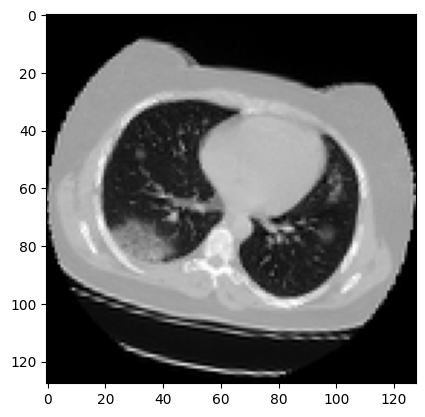

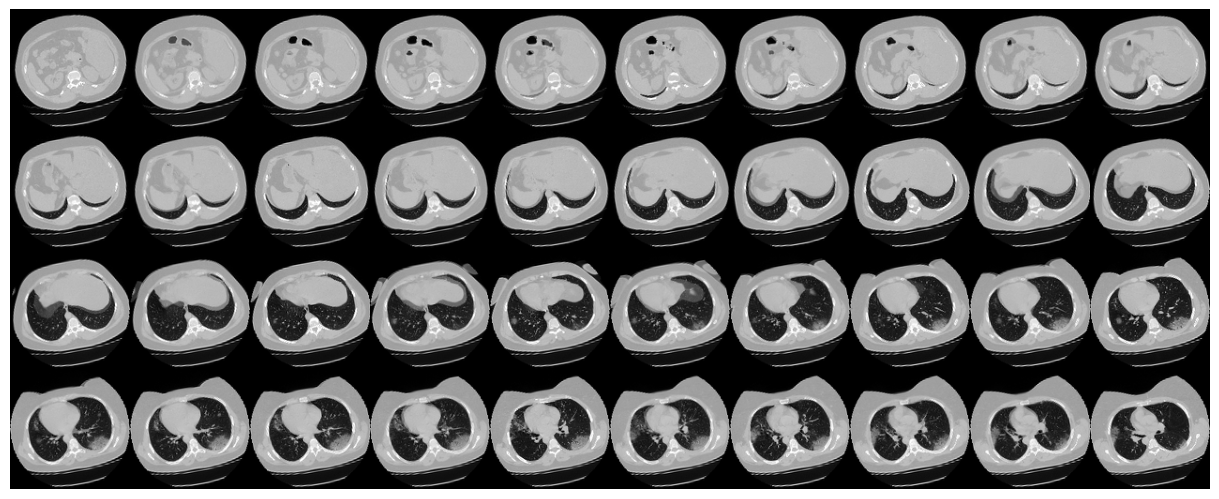

In [11]:
data = train_dataset.take(1)
images, labels = list(data)[0]
images = images.numpy()
image = images[0]
print("CT Scan Dims:", image.shape)
# CT Scan Dims: (128, 128, 64, 1)
plt.imshow(np.squeeze(image[:, :, 30]), cmap="gray")

# Visualize montage of slices.
# 4 rows and 10 columns for 100 slices of the CT scan.
plot_slices(4, 10, 128, 128, image[:, :, :40])

![3D Image Classification](./assets/3D_Image_Classification_02.png)

![3D Image Classification](./assets/3D_Image_Classification_03.png)

## Building the Model

In [6]:
model = build_model(width=128, height=128, depth=64)
model.summary()

Model: "3dctscan"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 64, 1)  0         
                             ]                                   
                                                                 
 conv3d (Conv3D)             (None, 126, 126, 62, 64)  1792      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 63, 63, 31, 64)   0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 63, 63, 31, 64)   256       
 ormalization)                                                   
                                                                 
 conv3d_1 (Conv3D)           (None, 61, 61, 29, 64)    110656    
                                                          

2023-04-17 15:07:50.829935: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-17 15:07:50.830201: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-17 15:07:50.830364: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

```bash
Model: "3dctscan"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
=================================================================
 input_3 (InputLayer)        [(None, 128, 128, 64, 1)  0         
                             ]                                   
                                                                 
 conv3d_9 (Conv3D)           (None, 126, 126, 62, 64)  1792      
                                                                 
 max_pooling3d_8 (MaxPooling  (None, 63, 63, 31, 64)   0         
 3D)                                                             
                                                                 
 batch_normalization_8 (Batc  (None, 63, 63, 31, 64)   256       
 hNormalization)                                                 
                                                                 
 conv3d_10 (Conv3D)          (None, 61, 61, 29, 64)    110656    
                                                                 
 max_pooling3d_9 (MaxPooling  (None, 30, 30, 14, 64)   0         
 3D)                                                             
                                                                 
 batch_normalization_9 (Batc  (None, 30, 30, 14, 64)   256       
 hNormalization)                                                 
                                                                 
 conv3d_11 (Conv3D)          (None, 28, 28, 12, 128)   221312    
                                                                 
 max_pooling3d_10 (MaxPoolin  (None, 14, 14, 6, 128)   0         
 g3D)                                                            
                                                                 
 batch_normalization_10 (Bat  (None, 14, 14, 6, 128)   512       
 chNormalization)                                                
                                                                 
 conv3d_12 (Conv3D)          (None, 12, 12, 4, 256)    884992    
                                                                 
 max_pooling3d_11 (MaxPoolin  (None, 6, 6, 2, 256)     0         
 g3D)                                                            
                                                                 
 batch_normalization_11 (Bat  (None, 6, 6, 2, 256)     1024      
 chNormalization)                                                
                                                                 
 global_average_pooling3d_1   (None, 256)              0         
 (GlobalAveragePooling3D)                                        
                                                                 
 dense_2 (Dense)             (None, 512)               131584    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 513       
                                                                 
=================================================================
Total params: 1,352,897
Trainable params: 1,351,873
Non-trainable params: 1,024
_________________________________________________________________
```

### Compile the Model

In [13]:
initial_learning_rate = 0.0001

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

model.compile(
    loss='binary_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=['acc']
)

### Callbacks

In [14]:
cp_cb = keras.callbacks.ModelCheckpoint(
    './checkpoints/3dct_weights.h5',
    save_best_only=True
)

es_cb = keras.callbacks.EarlyStopping(
    monitor='val_acc',
    patience=15
)

## Model Training

In [15]:
epochs = 100

model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=2,
    callbacks=[cp_cb, es_cb]
)
# Epoch 46/100
# 70/70 - 22s - loss: 0.3383 - acc: 0.8429 - val_loss: 0.8225 - val_acc: 0.6833 - 22s/epoch - 313ms/step

Epoch 1/100


2023-04-17 14:20:15.194909: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [140]
	 [[{{node Placeholder/_1}}]]
2023-04-17 14:20:15.195174: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [140]
	 [[{{node Placeholder/_1}}]]
2023-04-17 14:20:17.434457: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8800
2023-04-17 14:20:18.846931: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7fb7170e25c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-

70/70 - 27s - loss: 0.7101 - acc: 0.5429 - val_loss: 1.0012 - val_acc: 0.5167 - 27s/epoch - 384ms/step
Epoch 2/100
70/70 - 20s - loss: 0.6888 - acc: 0.5714 - val_loss: 1.3156 - val_acc: 0.5167 - 20s/epoch - 288ms/step
Epoch 3/100
70/70 - 20s - loss: 0.6796 - acc: 0.5929 - val_loss: 1.3741 - val_acc: 0.5167 - 20s/epoch - 285ms/step
Epoch 4/100
70/70 - 21s - loss: 0.6430 - acc: 0.6286 - val_loss: 2.0497 - val_acc: 0.5167 - 21s/epoch - 299ms/step
Epoch 5/100
70/70 - 20s - loss: 0.6460 - acc: 0.6643 - val_loss: 2.0223 - val_acc: 0.5167 - 20s/epoch - 281ms/step
Epoch 6/100
70/70 - 21s - loss: 0.6203 - acc: 0.6857 - val_loss: 2.0760 - val_acc: 0.5167 - 21s/epoch - 294ms/step
Epoch 7/100
70/70 - 21s - loss: 0.6572 - acc: 0.5786 - val_loss: 1.7401 - val_acc: 0.5167 - 21s/epoch - 304ms/step
Epoch 8/100
70/70 - 23s - loss: 0.6192 - acc: 0.6857 - val_loss: 0.9692 - val_acc: 0.5333 - 23s/epoch - 324ms/step
Epoch 9/100
70/70 - 21s - loss: 0.6014 - acc: 0.6929 - val_loss: 0.8898 - val_acc: 0.5833 - 

### Visualizing Model Performance

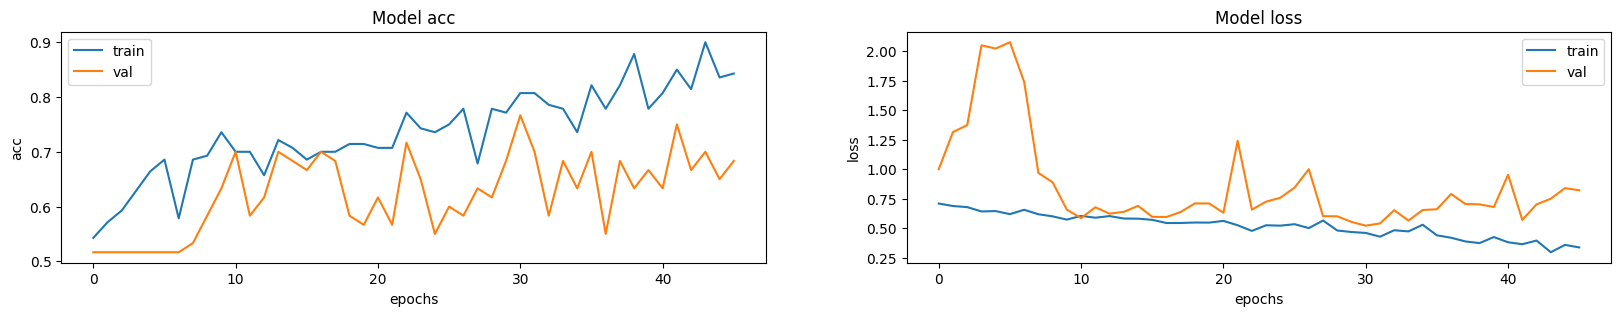

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss"]):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

![3D Image Classification](./assets/3D_Image_Classification_04.png)

## Loading Best Training Weights

In [7]:
model.load_weights('./checkpoints/3dct_weights.h5')

## Make Predictions

1/1 [==============================] - 0s 22ms/step


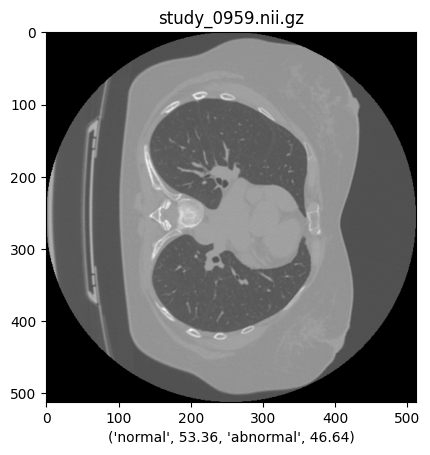

In [16]:
pred_dataset = './predictions'
pred_paths = [os.path.join(pred_dataset, i) for i in os.listdir(pred_dataset)]

z_val = np.array([process_scan(path) for path in pred_paths])

for i in range(len(z_val)):
    prediction = model.predict(np.expand_dims(z_val[i], axis=0))[0]
    scores = [1 - prediction[0], prediction[0]]
    class_names = ['normal', 'abnormal']
    
pred_image = nib.load(pred_paths[i])
pred_image_data = pred_image.get_fdata()

normal_class = class_names[0], round(100*scores[0], 2)
abnormal_class = class_names[1], round(100*scores[1], 2)
annotation = normal_class + abnormal_class

plt.imshow(pred_image_data[:,:, pred_image_data.shape[2]//2], cmap='gray')
plt.title(os.path.basename(pred_paths[i]))
plt.xlabel(annotation)
plt.show()

![3D Image Classification](./assets/3D_Image_Classification_05.png)

In [10]:
print(scores, class_names)

[0.5335640609264374, 0.46643594] ['normal', 'abnormal']
